# script that takes the aggregated data from the previous step and creates tables that are good for annotating GWAS files

# note that we cannot provide raw genotypes for the patients, so this script is here only as a reference and it cannot be run

In [1]:
import pandas as pd
import numpy as np
import os
import scipy
import pybedtools as pbed 
import subprocess as sub
from multiprocessing import Pool
import math
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multitest
import gzip
import subprocess
import vcf
import functools
import pickle
os.makedirs("/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools/", exist_ok = True)
pbed.helpers.set_tempdir("/mnt/iusers01/jw01/mdefscs4/scratch/temp_pybedtools/")
bed_genome_file = "/mnt/iusers01/jw01/mdefscs4/hg38.genome"

plt.rcParams['svg.fonttype'] = 'none'

base_dir = "/mnt/jw01-aruk-home01/projects/psa_functional_genomics/PsA_cleaned_analysis"

In [2]:
metadata_hic = pd.read_csv(f"{base_dir}/metadata/cleaned_HiC_metadata.csv", index_col=0)

In [12]:
data_CD4 = pickle.load(open(f"{base_dir}/HiC_allelic_imbalance/aggregated_data_CD4_slop10kb_separatepval.pk", "rb"))
data_CD8 = pickle.load(open(f"{base_dir}/HiC_allelic_imbalance/aggregated_data_CD8_slop10kb_separatepval.pk", "rb"))

In [13]:
merged_data_CD4 = {k: v for d in data_CD4 for k, v in d.items()}
merged_data_CD8 = {k: v for d in data_CD8 for k, v in d.items()}
print(len(merged_data_CD4))
print(len(merged_data_CD8))

909355
918108


## add FDR correction to the p-values from the loops

In [14]:
def add_FDR(merged_data):
    all_combined_pvals = []
    for x in merged_data.values():
        all_combined_pvals.append(x["combined_p_val_greater"])
        all_combined_pvals.append(x["combined_p_val_less"])
    corrected_pvals = statsmodels.stats.multitest.multipletests(all_combined_pvals, method = "fdr_bh",alpha = 0.1)[1]
    i = 0
    for x in merged_data.values():
        x["corrected_p_val_greater"] = corrected_pvals[i]
        i=i+1
        x["corrected_p_val_less"] = corrected_pvals[i]
        i=i+1
    return merged_data

merged_data_CD4 = add_FDR(merged_data_CD4)
merged_data_CD8 = add_FDR(merged_data_CD8)

In [15]:
significant_interactions_CD4 = []
significant_data_CD4 = {}
for key,x in merged_data_CD4.items():
    if x["corrected_p_val_greater"] < 0.1 or x["corrected_p_val_less"] < 0.1 :
        significant_interactions_CD4.append(key)
        significant_data_CD4[key] = x
significant_interactions_CD8 = []
significant_data_CD8 = {}
for key,x in merged_data_CD8.items():
    if x["corrected_p_val_greater"] < 0.1 or x["corrected_p_val_less"] < 0.1 :
        significant_interactions_CD8.append(key)
        significant_data_CD8[key] = x

## filter the significant interactions so that at least 80% of the samples have the right ratio

this is secondary to the fact that the p-values are directional because it's one-sided test

In [16]:
def get_really_significant(significant_data):
    for key, value in significant_data.items():
        plus_signs = 0
        minus_signs = 0
        reads_0 = 0
        reads_1 = 1
        n_pat = 0
        for sample in metadata_hic["folder_name"].to_list():
            try:
                if value[f"{sample}_1"]/(value[f"{sample}_0"]+value[f"{sample}_1"]) > 0.5:
                    plus_signs = plus_signs + 1
                else: 
                    minus_signs = minus_signs + 1
                reads_0 = reads_0 + value[f"{sample}_0"]
                reads_1 = reads_1 + value[f"{sample}_1"]
                n_pat = n_pat + 1
            except:
                continue
                
        ratio = plus_signs/(minus_signs+plus_signs)
        value["ratio"] = ratio
        if ratio > 0.8 or ratio < 0.2:
            value["good_ratio"] = True
        else: 
            value["good_ratio"] = False
        value["tot_REF"] = reads_0
        value["tot_ALT"] = reads_1
        value["n_pat"] = n_pat
    really_significant_data = {k:v for k,v in significant_data.items() if v["good_ratio"]}
    return really_significant_data
really_significant_data_CD4 = get_really_significant(significant_data_CD4)
really_significant_data_CD8 = get_really_significant(significant_data_CD8)

In [17]:
print(len(really_significant_data_CD4))
print(len(really_significant_data_CD8))

6589
6675


In [18]:
print(len(set([x.split("_")[1] for x in really_significant_data_CD4.keys()])))
print(len(set([x.split("_")[1] for x in really_significant_data_CD8.keys()])))

1543
1602


## re-annotate the position of the variants
this won't work if you don't have the file for the genotypes which are not made available

In [19]:
var_matcher = {}
for chrom in range(1,23):
    vcf_f = pbed.BedTool(f"/mnt/jw01-aruk-home01/projects/psa_functional_genomics/PsA_combined_analysis/allele_specific_hic/genotype_calling/called_genotypes/HAPCUT_phased_merged_chr{chrom}_annotated_filtered.vcf.gz")
    loop_anchors = pbed.BedTool("/mnt/jw01-aruk-home01/projects/psa_functional_genomics/PsA_combined_analysis/allele_specific_hic/calling_allele_specific/loop_anchors_merged.bed")
    filtered_vcf = vcf_f.intersect(loop_anchors,u = True, header = True)

    variants = vcf.Reader(filename=filtered_vcf.fn)

    for record in variants:
        var_matcher[record.ID] = record.POS

this function is used to annotate the loop information

In [20]:
def retrieve_datatable(samples):
    sample = samples[0]
    counts = pd.read_csv(f"/mnt/jw01-aruk-home01/projects/psa_functional_genomics/PsA_combined_analysis/allele_specific_hic/calling_allele_specific/output_counts/{sample}.bedpe", sep ="\t", header = None)
    counts = counts[[0,1,2,3,4,5,6,7]]
    counts[6] = counts.index
    for sample in samples:
        counts_B = pd.read_csv(f"/mnt/jw01-aruk-home01/projects/psa_functional_genomics/PsA_combined_analysis/allele_specific_hic/calling_allele_specific/output_counts/{sample}.bedpe", sep ="\t", header = None)
        counts_B = counts_B.rename(columns={8:sample + "_A",9:sample + "_B"})
        counts_B[6] = counts_B.index
        counts = counts.merge(counts_B)
    counts_pbed = pbed.BedTool.from_dataframe(counts)
    return counts, counts_pbed
samples_CD4 = metadata_hic[metadata_hic["cell_type"] == "CD4"]["folder_name"].to_list()
samples_CD8 = metadata_hic[metadata_hic["cell_type"] == "CD8"]["folder_name"].to_list()
counts_CD4, counts_pbed_CD4 = retrieve_datatable(samples_CD4)
counts_CD8, counts_pbed_CD8 = retrieve_datatable(samples_CD8)

### finally prepare the table listing all the infomration about allele specific loops

In [21]:
output_dataframe_CD4 = pd.DataFrame(columns = "chrA startA endA chrB startB endB loopID loopScore rsID rsCoord combined_Pval_greater corrected_Pval_greater combined_Pval_less corrected_Pval_less tot_REF tot_ALT n_pat".split())
for key, x in really_significant_data_CD4.items():
    rsID, loopID = key.split("_")
    loop = counts_CD4.iloc[int(loopID)]
    output_dataframe_CD4.loc[key] = [loop[0],loop[1],loop[2],loop[3],loop[4],loop[5],loop[6],loop[7],rsID, var_matcher[rsID], x["combined_p_val_greater"], x["corrected_p_val_greater"], x["combined_p_val_less"], x["corrected_p_val_less"], x["tot_REF"], x["tot_ALT"], x["n_pat"]]

output_dataframe_CD8 = pd.DataFrame(columns = "chrA startA endA chrB startB endB loopID loopScore rsID rsCoord combined_Pval_greater corrected_Pval_greater combined_Pval_less corrected_Pval_less tot_REF tot_ALT n_pat".split())
for key, x in really_significant_data_CD8.items():
    rsID, loopID = key.split("_")
    loop = counts_CD8.iloc[int(loopID)]
    output_dataframe_CD8.loc[key] = [loop[0],loop[1],loop[2],loop[3],loop[4],loop[5],loop[6],loop[7],rsID, var_matcher[rsID], x["combined_p_val_greater"], x["corrected_p_val_greater"], x["combined_p_val_less"], x["corrected_p_val_less"], x["tot_REF"], x["tot_ALT"], x["n_pat"]]

In [27]:
output_dataframe_CD8.to_csv(f"{base_dir}/HiC_allelic_imbalance/output_dataframe_CD8.csv")
output_dataframe_CD4.to_csv(f"{base_dir}/HiC_allelic_imbalance/output_dataframe_CD4.csv")

output_dataframe_CD8.to_csv(f"{base_dir}/HiC_allelic_imbalance/allelic_imbalanced_loops_CD8.bedpe", index = False, sep = "\t")
output_dataframe_CD4.to_csv(f"{base_dir}/HiC_allelic_imbalance/allelic_imbalanced_loops_CD4.bedpe", index = False, sep = "\t")

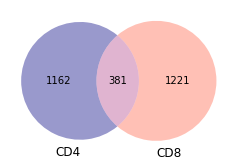

In [23]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

# Define the sets
set1 = set(output_dataframe_CD4["loopID"].to_list())
set2 = set(output_dataframe_CD8["loopID"].to_list())

fig, ax = plt.subplots(1,1,figsize=(4,4))
# Create the Venn diagram
v = venn2([set1, set2], set_colors=["navy","tomato"],set_labels=('CD4', 'CD8'), ax=ax)

# Show the plot
fig.savefig(f"{base_dir}/HiC_allelic_imbalance/figures/loops_allele_associated.svg", dpi = 600)